In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.signal as signal
import mat73 # for loading .mat files

from bubblewrap import Bubblewrap
from proSVD import proSVD
# from bubble_plots import plot_pred_entropy, draw_future


In [2]:
# Load data - from https://zenodo.org/record/3854034
# get unsorted vs sorted units
data_dict = mat73.loadmat('indy_20160407_02.mat')
units_unsorted = []
units_sorted = []
for ch_curr in data_dict['spikes']:
    units_unsorted.append(ch_curr[0]) # from data description, first unit is unsorted
    for unit_curr in ch_curr[1:]:
        if unit_curr is not None:
            units_sorted.append(unit_curr)

# getting binned spikes
bin_size_ms = 10
# window for binning
mintime, maxtime = 100, 0
for spk_times_curr in units_sorted:
    mintime = min(spk_times_curr[0], mintime)
    maxtime = max(spk_times_curr[-1], maxtime)
# get binned spikes
spk_bins = np.arange(mintime, maxtime, bin_size_ms/1000)
spks_binned = []
for i, unit_curr in enumerate(units_sorted):
    spks_binned_curr, _ = np.histogram(unit_curr, bins=spk_bins, range=(spk_bins[0], spk_bins[-1]))
    spks_binned.append(spks_binned_curr)
data = np.array(spks_binned).T
timesteps = int(1000 / bin_size_ms) # 1 second of data




In [4]:
data.shape

(82777, 174)

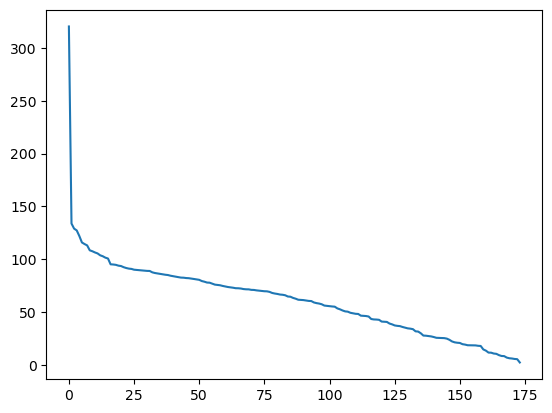

In [3]:
u, s, vh = np.linalg.svd(data, full_matrices=False)
plt.plot(s)

In [ ]:
#%%
# proSVD params
k = 6 # reduced dimension
trueSVD = True # whether proSVD should track true SVD basis (a little slower)
l = 1 # columns per update
l1 = 100 # columns used to initialize
decay = 1 # 1 = effective window is all of data
num_iters = np.floor((data.shape[0] - l1 - l)/l).astype('int')
update_times = np.arange(l1, num_iters*l, l) # index of when updates happen (not including init)

# smoothing params
kern_sd = 50
smooth_filt = signal.gaussian(int(6 * kern_sd / bin_size_ms), int(kern_sd / bin_size_ms), sym=True)
smooth_filt /=  np.sum(smooth_filt)
data_init_smooth = np.apply_along_axis(lambda x, filt: np.convolve(x, filt, 'same'),
                                       0, data[:l1, :], filt=smooth_filt)

# initialize proSVD
pro = proSVD(k=k, decay_alpha=decay, trueSVD=trueSVD, history=0)
pro.initialize(data_init_smooth.T)
# storing dimension-reduced data
data_red = np.zeros((data.shape[0], k))
data_red[:l1, :] = data_init_smooth @ pro.Q


# init bubblewrap
M = 20
N = 50
lam = 1e-3
nu = 1e-3
grads_per_obs = 1
step = 8e-3
d = k
num_d = k
T = data.shape[0] - M # iters
# sigma_scale = 1e3
B_thresh = -10
n_thresh = 5e-4
eps = 0
P = 0
t_wait = 1 # breadcrumbing
future_distance = 5
bw = Bubblewrap(num_d, N, d, step=step, lam=lam, eps=eps, M=M, nu=nu,
                t_wait=t_wait, n_thresh=n_thresh, B_thresh=B_thresh, lookahead_steps=5)


# run online
pro_end = int(data.shape[0]/8) # when proSVD will stop updating and bubblewrap starts
bubble_steps = 0 # number of steps bubblewrap has been active
pro_diffs = []
smooth_window = data[l1-len(smooth_filt):l1, :]
for i, t in enumerate(update_times):
    start, end = t, t+pro.w_len
    dat_curr = data[start:end, :]
    smooth_window[:-1, :] = smooth_window[1:, :]
    smooth_window[-1, :] = dat_curr
    dat_smooth = smooth_filt @ smooth_window

    # proSVD updates
    if t < pro_end:  # only update for first n steps
        pro.preupdate()
        pro.updateSVD(dat_smooth[:, None])
        pro.postupdate()
        pro_diffs.append(np.linalg.norm(pro.Q-pro.Q_prev, axis=0))

    # getting projected data
    data_red[start:end, :] = dat_smooth @ pro.Q

    # bubblewrap updates
    if t >= pro_end: # start bubblewrap
        if bubble_steps < M: # init bubbles
            bw.observe(data_red[t])
        if bubble_steps == M: # init nodes
            bw.init_nodes()
            print(f'Nodes initialized at bin {t}')
        if bubble_steps >= M: # update bubblewrap
            bw.observe(data_red[t])
            bw.e_step({future_distance: data_red[t+future_distance]})
            for j in range(grads_per_obs):
                bw.grad_Q()
        bubble_steps += 1

        if t % 100 == 0:
            print(f"step: {i},\tll: {bw.pred_list[-1][0]}")




[Text(0.5, 1.0, 'proSVD stabilizes with <1 min of data'),
 Text(0.5, 0, 'seconds of data seen'),
 Text(0, 0.5, '$|\\Delta\\mathbf{Q}|$')]

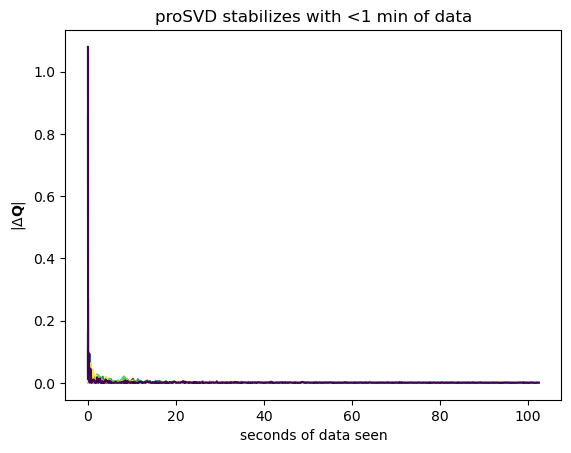

In [7]:
# Plotting - proSVD changes
fig, ax = plt.subplots()
pro_diffs = np.array(pro_diffs)
ax.plot(np.arange(pro_diffs.shape[0])/timesteps, pro_diffs)
ax.set(title='proSVD stabilizes with <1 min of data',
       xlabel='seconds of data seen',
       ylabel=r'$|\Delta\mathbf{Q}|$')# proSVD-reduced trials

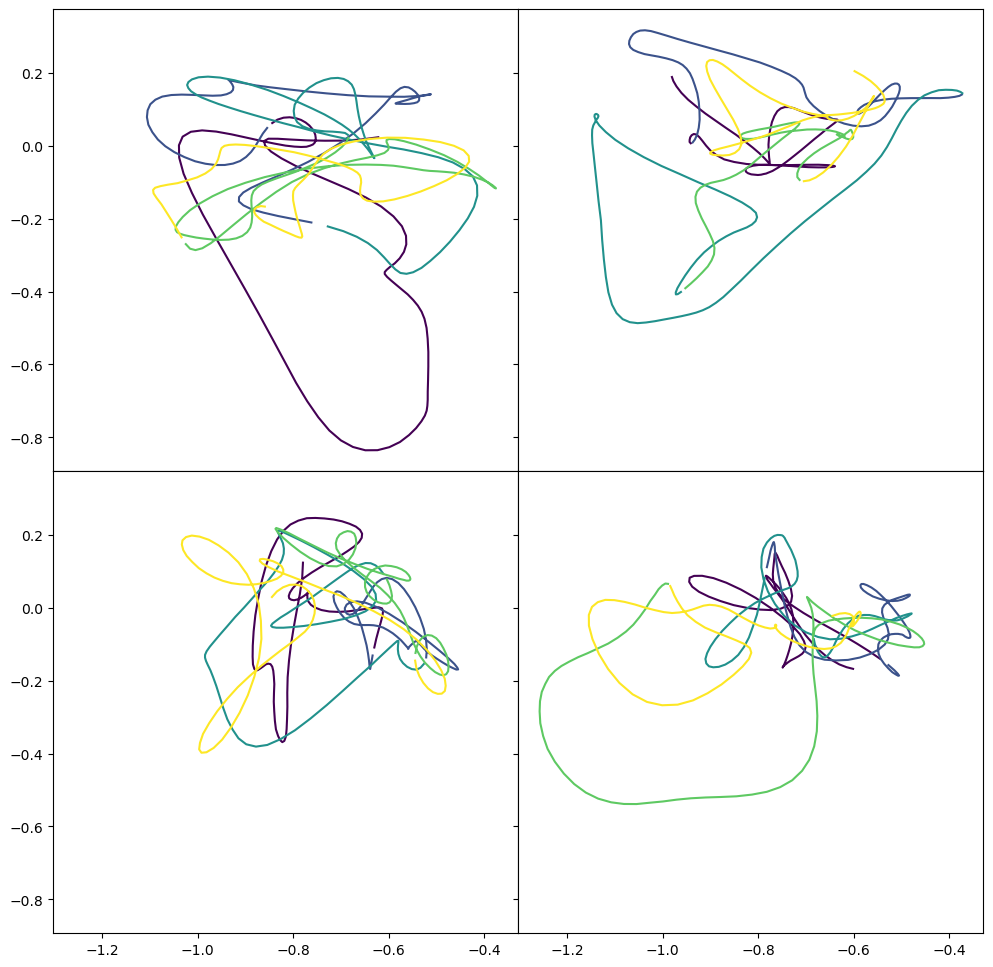

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
ax = ax.flatten()
for j, tr_start in enumerate([1, 10, 50, 500]):
    n_trials_plot = 5
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,n_trials_plot)))
    for i in range(n_trials_plot):
        start_bin = (tr_start+i) * timesteps
        xs, ys = [*data_red[start_bin:start_bin+timesteps, :2].T]
        ax[j].plot(xs, ys)

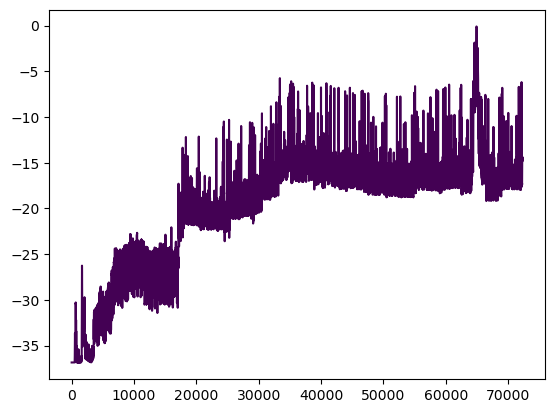

In [12]:
# bubblewrap learning
pred = np.array(bw.pred_list)
fig, ax = plt.subplots()
ax.plot(pred[:,0])


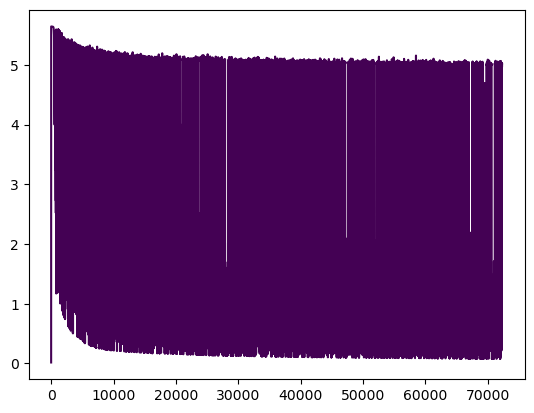

In [14]:
# bubblewrap learning
ent = np.array(bw.entropy_list)
fig, ax = plt.subplots()
ax.plot(ent[:,0])


In [ ]:
# prediction trial
for trial in np.arange(700, 701):
    start, end = trial*timesteps, (trial+1)*timesteps
    newtrial = data_red[start:end, :]
    fig, ax = plt.subplots(figsize=(5,7))
    ax = draw_future(bw, ax, n_bubbles_forward=8, n_conns=1, trial=newtrial[:-35], n_steps_in=15)
    ax.set(xlim=(-1.1,-.45), ylim=(-.4, .27))
    full_trials = np.floor( data_red[pro_end:int(T/2)].shape[0] / timesteps).astype('int')
    ind = 0
    for j in range(full_trials):
        ax.plot(data_red[ind:ind+timesteps, 0], data_red[ind:ind+timesteps, 1],
                alpha=.01, color='k', rasterized=True, zorder=99)
        ind += timesteps
    # if trial == 700:
    #     plt.savefig('bw_predict_trial.svg', bbox_inches='tight')
